In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
import geopandas
from shapely.geometry import Point
import fiona
pd.set_option('display.float_format', lambda x: '%.3f' % x)

### Creating a cross-walk of 2020 Census Tracts to 2010 Vintage PUMA Boundaries

#### Packages to install:
- geopandas, pandas, numpy, pyproj, six, fiona, shapely, rtree

#### Geopandas has dependencies and it can be tricky to make all of them work. Recommended installation methods:
1. install using the "conda-forge" community (<code>conda install -c conda-forge geopandas, fiona, shapely, rtree</code>)
2. or create a virtual environment containing OSMnx package (python package to download/analyze geospatial data from OpenStreetMap)

<code>install using conda config --prepend channels conda-forge
conda create -n ox --strict-channel-priority osmnx
conda activate ox
conda install jupyter
jupyter notebook
</code>

### 1. Import vintage 2010 PUMA Boundaries and Census Tracts Data (as of Decennial Census 2020) from the NYC Open Data Portal.

[2010 PUMA Boundaries](https://data.cityofnewyork.us/Housing-Development/2010-Public-Use-Microdata-Areas-PUMAs-/cwiz-gcty): Census-defined boundaries that roughly approximate the city's Community Districts. Each PUMA covers at least 100,000 residents.

[2020 Census Tracts](https://data.cityofnewyork.us/City-Government/2020-Census-Tracts-Tabular/63ge-mke6): The census tracts are small, permanent geographical unit of a county or its geographical equivalent. According to the Census Bureau, the number of people that reside in a census tract is between 1,200 and 8,000. Per Decennial 2010, there are 2,168 census tracts in NYC. 

Analyzing data for smaller geographies can allow for better analysis and census tracts tend to be great in that sense. However, their results should be interpreted with caution when using ACS estimates due to its small sample size.

### 1.1. Import Shapefiles from NYC Open Data.  *Source: Decennial Census 2020*

In [2]:
def import_shapefile_and_area_in_sqkm(four_by_four_code):
    '''
    Import a shapefile and calculate the area in square kilometer for each tile. 
    
    Input:
        - four_by_four_code: a string that contains 8 alphanumeric letters assigned 
           to each open dataset on NYC Open Data Portal.
    
    Returns:
        - a geopandas dataframe.
    
    '''
    
    # import the shapefile as GeoJSON from the open data portal
    request = requests.get("https://data.cityofnewyork.us/api/geospatial/" + \
                           four_by_four_code + "?method=export&format=GeoJSON")
    
    visz = fiona.ogrext.buffer_to_virtual_file(bytes(request.content))
    
    # read the features from a fiona collection into a GeoDataFrame
    with fiona.Collection(visz, driver='GeoJSON') as f:
        nyc_opendata_gpd = geopandas.GeoDataFrame.from_features(f, crs=f.crs)
    
    #***************************************#
    
    #Projection: how should geopandas intepret the coordinates?
    
    print("coordinate reference system of the shapefile: ", nyc_opendata_gpd.crs)
    
    # change projection to Mercator, and then square meter into square kilometer
    
    # source: https://gis.stackexchange.com/questions/218450/getting-polygon-areas-using-geopandas
    nyc_opendata_gpd['area_in_sqkm'] = nyc_opendata_gpd['geometry'].to_crs({'init': 'epsg:3395'})\
                   .map(lambda p: p.area / 10**6)
    
    #alternative method: convert the cartesian system into an equal projection area
    # nyc_opendata_gpd['area_in_sqkm_cea'] = nyc_opendata_gpd['geometry'].to_crs({'proj':'cea'})
    
    return nyc_opendata_gpd

![Some Projections](img/projections.jpg)

In [3]:
#this is the 4x4 code of 2010 vintage puma shapefile on the open data portal
puma_nyc = import_shapefile_and_area_in_sqkm("cwiz-gcty")

coordinate reference system of the shapefile:  +init=epsg:4326 +type=crs


C:\Users\CHUser\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\CHUser\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
puma_nyc.head()

,geometry,puma,shape_area,shape_leng,area_in_sqkm
0,"MULTIPOLYGON (((-73.89641 40.90450, -73.89636 ...",3701,97928516.6801,53227.1136077,15.874
1,"MULTIPOLYGON (((-73.86943 40.87813, -73.86950 ...",3702,188993662.321,106167.716965,30.636
2,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ...",3703,267643637.74,305269.139107,43.334
3,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",3704,106216907.291,47970.2030563,17.200
4,"MULTIPOLYGON (((-73.87046 40.86663, -73.87042 ...",3705,122484260.721,68704.1110155,19.828


In [5]:
puma_nyc['area_in_sqkm'].sum()

1350.7953537406142

In [6]:
puma_nyc['puma'].nunique()

55

In [7]:
puma_nyc.head()

,geometry,puma,shape_area,shape_leng,area_in_sqkm
0,"MULTIPOLYGON (((-73.89641 40.90450, -73.89636 ...",3701,97928516.6801,53227.1136077,15.874
1,"MULTIPOLYGON (((-73.86943 40.87813, -73.86950 ...",3702,188993662.321,106167.716965,30.636
2,"MULTIPOLYGON (((-73.78833 40.83467, -73.78931 ...",3703,267643637.74,305269.139107,43.334
3,"MULTIPOLYGON (((-73.84793 40.87134, -73.84725 ...",3704,106216907.291,47970.2030563,17.200
4,"MULTIPOLYGON (((-73.87046 40.86663, -73.87042 ...",3705,122484260.721,68704.1110155,19.828


Plot the map.

Text(0.5, 1.0, '2010 Vintage PUMAs')

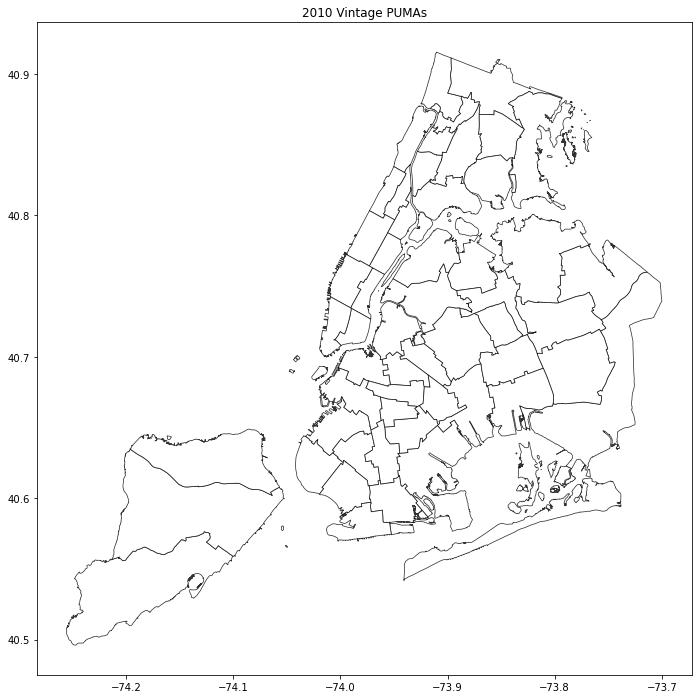

In [8]:
fig, ax = plt.subplots(figsize=(12, 12))

ax.set_aspect('equal')

puma_nyc.plot(ax=ax, color='white', edgecolor='black', linewidth=0.75, alpha=0.8)

plt.title("2010 Vintage PUMAs")

### 1.2. Import Census Tracts Shapefile from NYC Open Data. *Source: Decennial Census 2020*

In [9]:
census_tracts_2020_gpd = import_shapefile_and_area_in_sqkm("63ge-mke6")

C:\Users\CHUser\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\CHUser\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


coordinate reference system of the shapefile:  +init=epsg:4326 +type=crs


In [10]:
census_tracts_2020_gpd.shape

(2325, 15)

In [11]:
census_tracts_2020_gpd.head()

,geometry,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,area_in_sqkm
0,"MULTIPOLYGON (((-74.04388 40.69019, -74.04351 ...",1844421.2457,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),11023.0485015,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,0.297
1,"MULTIPOLYGON (((-73.98450 40.70951, -73.98655 ...",972312.097149,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),4754.49525,Manhattan,000201,MN0301,1,None,36061000201,1000201,MN03,2.01,0.157
2,"MULTIPOLYGON (((-73.98237 40.70554, -73.98246 ...",3315114.30385,Lower East Side,MN03 Lower East Side-Chinatown (CD 3 Equivalent),8568.0894293,Manhattan,000202,MN0302,1,None,36061000202,1000202,MN03,2.02,0.535
3,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...",9083214.44983,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),32642.0837451,Manhattan,000500,MN0191,1,None,36061000500,1000500,MN01,5,1.464
4,"MULTIPOLYGON (((-73.99022 40.71440, -73.98934 ...",2582705.23446,Chinatown-Two Bridges,MN03 Lower East Side-Chinatown (CD 3 Equivalent),6976.28645635,Manhattan,000600,MN0301,1,None,36061000600,1000600,MN03,6,0.416


Plot the map.

Text(0.5, 1.0, 'Census Tracts of NYC - Decennial Census 2020')

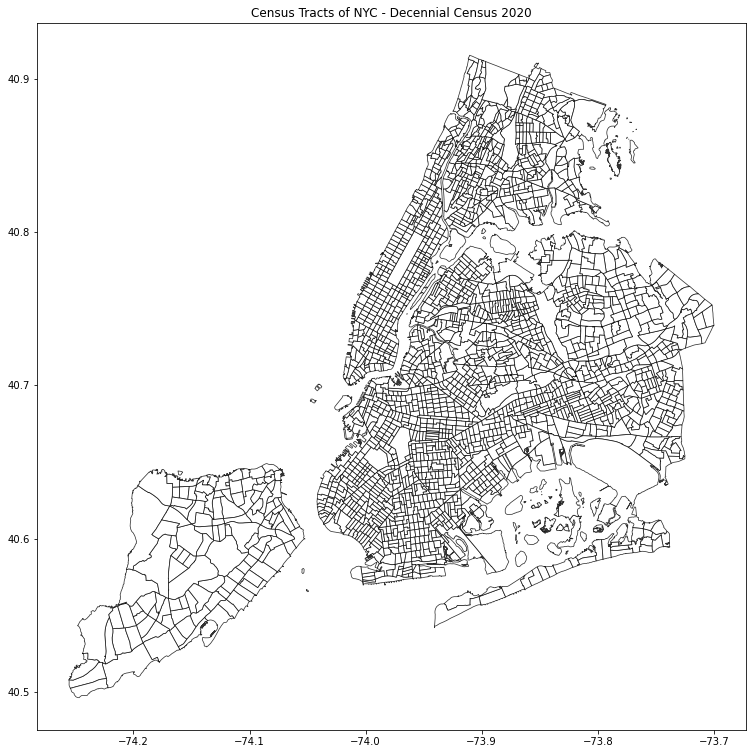

In [12]:
fig, ax = plt.subplots(figsize=(13, 13))
ax.set_aspect('equal')
census_tracts_2020_gpd.plot(ax=ax, color='white', edgecolor='black', linewidth=0.75, alpha=0.8)
plt.title("Census Tracts of NYC - Decennial Census 2020")

In [13]:
census_tracts_2020_gpd.crs

<Geographic 2D CRS: +init=epsg:4326 +type=crs>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

### 2. *Overlay* Census Tracts and PUMA shapefiles

From Geopandas [documentation](https://geopandas.org/gallery/overlays.html) on overlaying geographical areas:

"Spatial overlays allow you to compare two GeoDataFrames containing polygon or multipolygon geometries and create a new GeoDataFrame with the new geometries representing the spatial combination and merged properties."

![Overlay Methods](img/overlay.jpg)

In [14]:
#join on left (how much area in the left level occupies on the right level)
tract_to_puma_intersection = geopandas.overlay(census_tracts_2020_gpd, puma_nyc, how='intersection')

C:\Users\CHUser\AppData\Local\Temp\ipykernel_16392\2474350325.py:2: UserWarning: `keep_geom_type=True` in overlay resulted in 1878 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  tract_to_puma_intersection = geopandas.overlay(census_tracts_2020_gpd, puma_nyc, how='intersection')


In [15]:
tract_to_puma_intersection.head(3)

,shape_area_1,ntaname,cdtaname,shape_leng_1,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,area_in_sqkm_1,puma,shape_area_2,shape_leng_2,area_in_sqkm_2,geometry
0,1844421.2457,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),11023.0485015,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,0.297,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-74.03945 40.70053, -74.03938 ..."
1,9083214.44983,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),32642.0837451,Manhattan,000500,MN0191,1,None,36061000500,1000500,MN01,5,1.464,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-74.00070 40.69061, -74.00479 ..."
2,2439446.25561,Financial District-Battery Park City,MN01 Financial District-Tribeca (CD 1 Equivalent),9763.04287952,Manhattan,000700,MN0101,1,None,36061000700,1000700,MN01,7,0.393,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-73.99802 40.69876, -74.00002 ..."


In [16]:
tract_to_puma_intersection.shape

(3214, 19)

Text(0.5, 1.0, 'Map of 2010 NYC PUMA (red border) and 2020 Census Tracts (white border) Overlapped')

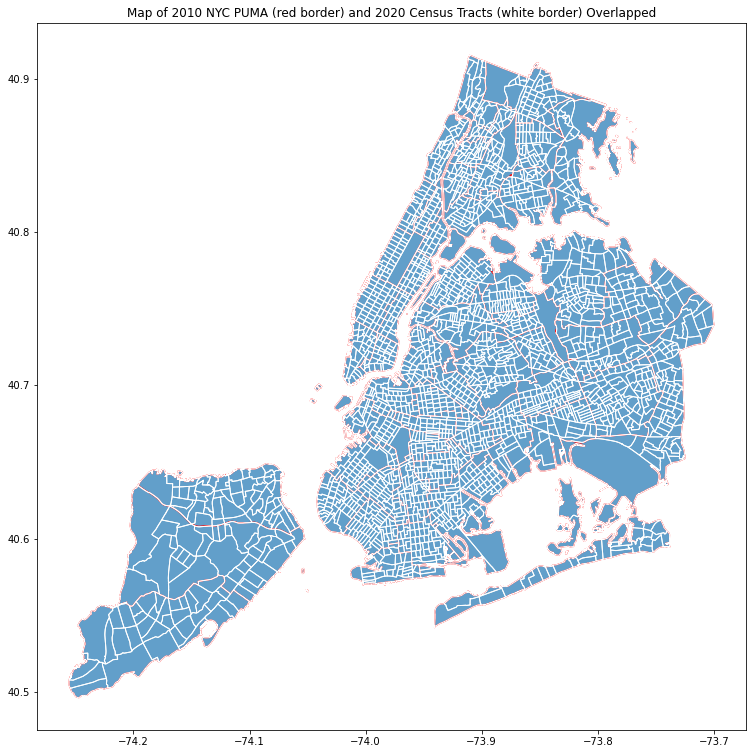

In [55]:
ax = tract_to_puma_intersection.plot(alpha=0.7, figsize=(13, 13))

puma_nyc.plot(ax=ax, facecolor='none', edgecolor='r')
census_tracts_2020_gpd.plot(ax=ax, facecolor='none', edgecolor='w')

plt.title("Map of 2010 NYC PUMA (red border) and 2020 Census Tracts (white border) Overlapped")

If there were any areas that were not filled with blue color, that would indicate that there's no overlapping boundaries between census tracts and pumas.

### 3. After overlaying, calculate the intersection area into square km and identify the tract-to-puma ratio

In [18]:
# calculate intersection area into square km
tract_to_puma_intersection['intersection_sqkm'] = \
                tract_to_puma_intersection['geometry'].to_crs({'init': 'epsg:3395'})\
               .map(lambda p: p.area / 10**6)

C:\Users\CHUser\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [19]:
tract_to_puma_intersection.head()

,shape_area_1,ntaname,cdtaname,shape_leng_1,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,area_in_sqkm_1,puma,shape_area_2,shape_leng_2,area_in_sqkm_2,geometry,intersection_sqkm
0,1844421.2457,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),11023.0485015,Manhattan,000100,MN0191,1,None,36061000100,1000100,MN01,1,0.297,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-74.03945 40.70053, -74.03938 ...",0.297
1,9083214.44983,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),32642.0837451,Manhattan,000500,MN0191,1,None,36061000500,1000500,MN01,5,1.464,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-74.00070 40.69061, -74.00479 ...",1.464
2,2439446.25561,Financial District-Battery Park City,MN01 Financial District-Tribeca (CD 1 Equivalent),9763.04287952,Manhattan,000700,MN0101,1,None,36061000700,1000700,MN01,7,0.393,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-73.99802 40.69876, -74.00002 ...",0.393
3,3130256.303,Financial District-Battery Park City,MN01 Financial District-Tribeca (CD 1 Equivalent),16486.6156624,Manhattan,000900,MN0101,1,None,36061000900,1000900,MN01,9,0.505,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-73.99862 40.69761, -73.99887 ...",0.505
4,3412791.24246,Financial District-Battery Park City,MN01 Financial District-Tribeca (CD 1 Equivalent),8814.26300684,Manhattan,001300,MN0101,1,None,36061001300,1001300,MN01,13,0.550,3810,81024704.3617,122526.958758,13.066,"POLYGON ((-74.00906 40.71089, -74.00947 40.710...",0.550


Add a metric to show a) the proportion of a single tract that falls in a puma

In [20]:
tract_to_puma_intersection['tract_percent_of_puma_km'] = \
    tract_to_puma_intersection['intersection_sqkm']/tract_to_puma_intersection['area_in_sqkm_1']

In [21]:
tract_to_puma_intersection.head()

,shape_area_1,ntaname,cdtaname,shape_leng_1,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,...,cdta2020,ctlabel,area_in_sqkm_1,puma,shape_area_2,shape_leng_2,area_in_sqkm_2,geometry,intersection_sqkm,tract_percent_of_puma_km
0,1844421.2457,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),11023.0485015,Manhattan,000100,MN0191,1,None,36061000100,...,MN01,1,0.297,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-74.03945 40.70053, -74.03938 ...",0.297,1.000
1,9083214.44983,The Battery-Governors Island-Ellis Island-Libe...,MN01 Financial District-Tribeca (CD 1 Equivalent),32642.0837451,Manhattan,000500,MN0191,1,None,36061000500,...,MN01,5,1.464,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-74.00070 40.69061, -74.00479 ...",1.464,1.000
2,2439446.25561,Financial District-Battery Park City,MN01 Financial District-Tribeca (CD 1 Equivalent),9763.04287952,Manhattan,000700,MN0101,1,None,36061000700,...,MN01,7,0.393,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-73.99802 40.69876, -74.00002 ...",0.393,1.000
3,3130256.303,Financial District-Battery Park City,MN01 Financial District-Tribeca (CD 1 Equivalent),16486.6156624,Manhattan,000900,MN0101,1,None,36061000900,...,MN01,9,0.505,3810,81024704.3617,122526.958758,13.066,"MULTIPOLYGON (((-73.99862 40.69761, -73.99887 ...",0.505,1.000
4,3412791.24246,Financial District-Battery Park City,MN01 Financial District-Tribeca (CD 1 Equivalent),8814.26300684,Manhattan,001300,MN0101,1,None,36061001300,...,MN01,13,0.550,3810,81024704.3617,122526.958758,13.066,"POLYGON ((-74.00906 40.71089, -74.00947 40.710...",0.550,1.000


In [22]:
tract_to_puma_intersection_groupby = tract_to_puma_intersection.dissolve(
    by=['geoid',  'ct2020', 'ctlabel', 'puma', 'nta2020', 'ntaname', 'cdtaname', 'boroname', 'borocode'],
    aggfunc='sum'
    ).reset_index()

No tract falls below 90% of intersection in a specific puma, except for one tract '070203' that does not intersect with any puma. Therefore, only select tracts that cover majority of the areas.

In [32]:
final_tract_to_puma_crosswalk = tract_to_puma_intersection_groupby[(tract_to_puma_intersection_groupby['tract_percent_of_puma_km'] > 0.10)]

In [33]:
final_tract_to_puma_crosswalk.shape

(2324, 14)

In [34]:
#QA to ensure that PUMAs match with their boroughs
final_tract_to_puma_crosswalk.groupby(['boroname', 'puma']).size().reset_index(name='number of tracts')

,boroname,puma,number of tracts
0,Bronx,3701,28
1,Bronx,3702,46
2,Bronx,3703,33
3,Bronx,3704,42
4,Bronx,3705,42
5,Bronx,3706,25
6,Bronx,3707,33
7,Bronx,3708,30
8,Bronx,3709,42
9,Bronx,3710,40


It appears that 'puma 4101' in Staten Island is invalid. 4101 belongs to Queens. Let's find out what that is!

In [38]:
final_tract_to_puma_crosswalk[((final_tract_to_puma_crosswalk['puma'] =='4101') &\
                               (final_tract_to_puma_crosswalk['boroname'] == 'Staten Island'))]

,geoid,ct2020,ctlabel,puma,nta2020,ntaname,cdtaname,boroname,borocode,geometry,area_in_sqkm_1,area_in_sqkm_2,intersection_sqkm,tract_percent_of_puma_km
3213,36085990100,990100,9901,4101,SI9591,Hoffman & Swinburne Islands,SI95 Great Kills Park-Fort Wadsworth (JIA 95 A...,Staten Island,5,"MULTIPOLYGON (((-74.05030 40.56642, -74.05013 ...",0.102,23.228,0.102,1.000


In [43]:
#remove this tract and then export the final to csv and shapefiles
final_tract_to_puma_crosswalk = final_tract_to_puma_crosswalk[~((final_tract_to_puma_crosswalk['puma'] =='4101') &\
                               (final_tract_to_puma_crosswalk['boroname'] == 'Staten Island'))]

In [44]:
final_tract_to_puma_crosswalk.shape

(2323, 14)

In [49]:
final_tract_to_puma_crosswalk.to_file("census_tract_2020_to_puma_2010_crosswalk_shapefile.shp")

C:\Users\CHUser\anaconda3\envs\ox\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
C:\Users\CHUser\AppData\Local\Temp\ipykernel_16392\699124075.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  final_tract_to_puma_crosswalk.to_file("census_tract_2020_to_puma_2010_crosswalk_shapefile.shp")


In [51]:
final_tract_to_puma_crosswalk.drop(columns='geometry').to_csv("census_tract_2020_to_puma_2010_crosswalk_tabular.csv", index=False)

### 4. Demo: Investigate the census tracts '070203' in BK and '990100' in SI that don't intersect with a PUMA

In [52]:
jamaca_bay_and_staten_island_census_tracts = census_tracts_2020_gpd[census_tracts_2020_gpd['ntaname'].isin(['Jamaica Bay (West)', \
                                                                            'Hoffman & Swinburne Islands'])]

#intersect the tracts and 
puma_jamaica_bay_and_tracts_intersection = geopandas.overlay(puma_nyc, \
                                                                jamaca_bay_and_staten_island_census_tracts, how='intersection')

In [53]:
jamaca_bay_and_staten_island_census_tracts

,geometry,shape_area,ntaname,cdtaname,shape_leng,boroname,ct2020,nta2020,borocode,cdeligibil,geoid,boroct2020,cdta2020,ctlabel,area_in_sqkm
1261,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...",39754276.7994,Jamaica Bay (West),BK56 Jamaica Bay (West) (JIA 56 Approximation),136901.829212,Brooklyn,070203,BK5692,3,None,36047070203,3070203,BK56,702.03,6.390
2324,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...",635701.967583,Hoffman & Swinburne Islands,SI95 Great Kills Park-Fort Wadsworth (JIA 95 A...,4743.12812675,Staten Island,990100,SI9591,5,None,36085990100,5990100,SI95,9901,0.102


C:\Users\CHUser\anaconda3\envs\ox\lib\site-packages\pyproj\crs\crs.py:130: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


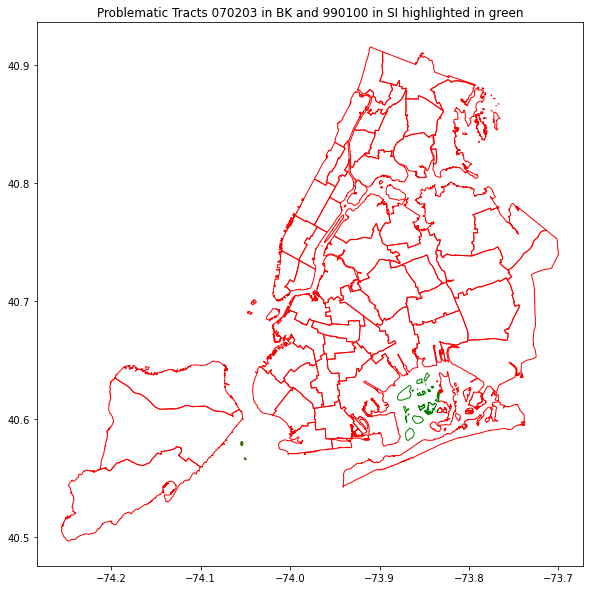

In [54]:
ax = puma_jamaica_bay_and_tracts_intersection.plot(figsize=(10, 10))

# plot the ED's and census tracts of Prospect Heights
puma_nyc.plot(ax=ax, facecolor='none', edgecolor='r')

jamaca_bay_and_staten_island_census_tracts.plot(ax=ax, facecolor='none', edgecolor='g')

plt.title("Problematic Tracts 070203 in BK and 990100 in SI highlighted in green")

# jamaca_bay_census_tracts.apply(lambda x: ax.annotate(s=x['ct2020'], \
#         xy=x.geometry.centroid.coords[0], ha='right'),axis=1);

# Calculate the intersection area of census tracts and pumas in square kilometer
puma_jamaica_bay_and_tracts_intersection['intersection_sqkm'] = \
        puma_jamaica_bay_and_tracts_intersection['geometry'].to_crs({'init': 'epsg:3395'})\
       .map(lambda p: p.area / 10**6)

# calculate the metrics that show proportion of each census tract and puma
puma_jamaica_bay_and_tracts_intersection['tract_area_percent_of_puma_km'] = \
        puma_jamaica_bay_and_tracts_intersection['intersection_sqkm']/\
        puma_jamaica_bay_and_tracts_intersection['area_in_sqkm_1']

#annonate the first metric i.e. "what percent of puma is occupied by the census tract?" on the map
# puma_jamaica_bay_and_tracts_intersection.apply(\
#                 lambda x: ax.annotate(s=round(x['tract_area_percent_of_puma_km'], 2),\
#                 xy=x.geometry.centroid.coords[0], ha='left', color='w'),axis=1);